In [1]:
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/master
!pip3 install --upgrade pip

Cloning into 'waymo-od'...
remote: Enumerating objects: 884, done.
remote: Total 884 (delta 0), reused 0 (delta 0), pack-reused 884
Receiving objects: 100% (884/884), 14.19 MiB | 41.62 MiB/s, done.
Resolving deltas: 100% (580/580), done.
* master
  remotes/origin/HEAD -> origin/master
  remotes/origin/master
  remotes/origin/r1.0
  remotes/origin/r1.0-tf1.15
  remotes/origin/r1.0-tf2.0
  remotes/origin/r1.2
Note: checking out 'remotes/origin/master'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at a476ab4 Add python 3.8 support
     |████████████████████████████████| 1.5MB 8.9MB/s 
  Found existing installation: pip 19.3.

In [2]:
!pip3 install waymo-open-dataset-tf-2-1-0==1.2.0
!pip3 install opencv-python

     |████████████████████████████████| 2.8 MB 8.6 MB/s 
     |████████████████████████████████| 421.8 MB 2.4 kB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
     |████████████████████████████████| 3.8 MB 68.1 MB/s 
     |████████████████████████████████| 448 kB 66.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7540 sha256=dbf82c8a345bafd698934937fd62f64171776ec11e938ab5f4d8739969be9260
  Stored in directory: /root/.cache/pip/wheels/19/a7/b9/0740c7a3a7d1d348f04823339274b90de25fbcd217b2ee1fbe
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: gast
    Found existing installa

In [43]:
import os
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt

tf.enable_eager_execution()

from sklearn.preprocessing import OneHotEncoder
from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


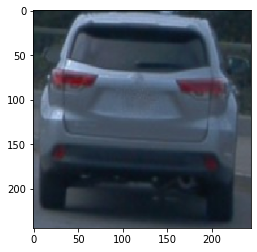

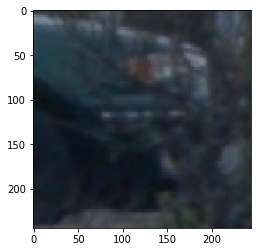

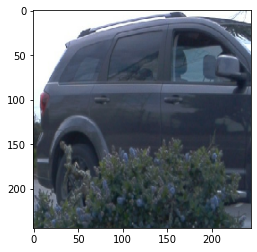

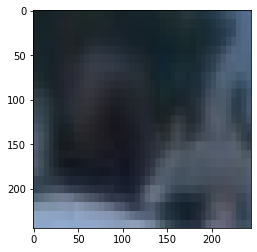

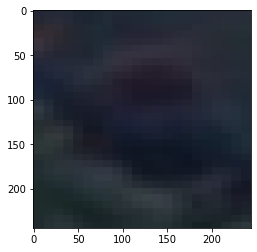

In [92]:
FILENAME = '/content/waymo-od/tutorial/frames'
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='').shuffle(10).take(2)
encoder = OneHotEncoder(sparse=False)
encoder.fit([[0], [1], [2], [3], [4]])

def img_generator():
  for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    labels = {}
    boxes = {}
    for cam_label in frame.camera_labels:
      if cam_label is None: 
        continue
      if cam_label.name not in labels.keys():
        labels[cam_label.name] = []
      if cam_label.name not in boxes.keys():
        boxes[cam_label.name] = []
      for label in cam_label.labels:
        labels[cam_label.name].append(encoder.transform([[label.type]])[0])

        xi = int(label.box.center_x - 0.5 * label.box.length)
        xf = int(label.box.length)
        yi = int(label.box.center_y - 0.5 * label.box.width)
        yf = int(label.box.width)
        boxes[cam_label.name].append([yi, xi, yf, xf])
    for cam_image in frame.images:
      decoded_img = tf.image.decode_jpeg(cam_image.image)
      for label, box in zip(labels[cam_image.name], boxes[cam_image.name]):
        cimg = tf.image.crop_to_bounding_box(decoded_img, box[0],box[1],box[2],box[3])
        cimg = tf.image.resize(cimg, (244,244), method='nearest')
        yield cimg, label
  raise StopIteration

dataset2 = tf.data.Dataset.from_generator(img_generator, output_types=(tf.uint8, tf.float32))

for d in dataset2.shuffle(10).take(5):
  print(d[1])
  plt.figure()
  plt.imshow(d[0])

# Data Processing

Used the waymo-open dataset [tutorial](https://colab.research.google.com/github/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial.ipynb#scrollTo=18KfxT8RkMv0)

The notebook reads in a single record from the TFRecord file and extracts labeled images. They're resized to (244,244) for processing and displayed. The dataset labels partial objects so some of the samples don't have the full object in view. I'm also filtering out small objects.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def show_camera_image(camera_image, camera_labels):
  """Show a camera image and the given camera labels."""
  
  x = []
  y = []
  # Draw the camera labels.
  for camera_labels in frame.camera_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      xi = int(label.box.center_x - 0.5 * label.box.length)
      xf = int(xi + label.box.length)
      yi = int(label.box.center_y - 0.5 * label.box.width)
      yf = int(yi + label.box.width)

      if label.box.width < 122 or label.box.length < 122: continue
      img = tf.image.decode_jpeg(camera_image.image).numpy()
      temp_image = img[yi:yf,xi:xf,:]
      temp_image = cv2.resize(temp_image, (244,244), interpolation = cv2.INTER_AREA)
      plt.figure()      
      plt.imshow(temp_image,cmap='brg')
      temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
      print(label.type)
      x.append(temp_image)
      y.append(label.type)
      return x, y

x_data = []
y_data = []
for index, image in enumerate(frame.images):
  x, y = show_camera_image(image, frame.camera_labels)
  x_data = x_data + x
  y_data = y_data + y



In [ ]:
import tensorflow_hub as hub

num_classes = 7
y_data_encoded = tf.keras.utils.to_categorical(y_data, num_classes=num_classes)
x = np.array(x_data) / 255.0
# x_ds = tf.data.Dataset.from_generator(x_data.__iter__, tf.float32).map(lambda x: x / 255.0)
# y_ds = tf.data.Dataset.from_generator(y_data_encoded.__iter__, tf.float32)

m = tf.keras.Sequential()
m.add(hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4",
                   trainable=True))
m.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

m.build([None, 224, 224, 3])  # Batch input shape.
m.compile(loss='categorical_crossentropy', metrics=['accuracy'])
m.fit(x=x, y=y_data_encoded, epochs=3)

In [ ]:
score = m.evaluate(x=x,y=y_data_encoded)
print(score)